# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print "TensorFlow Version {}".format(tf.__version__)

TensorFlow Version 1.3.0


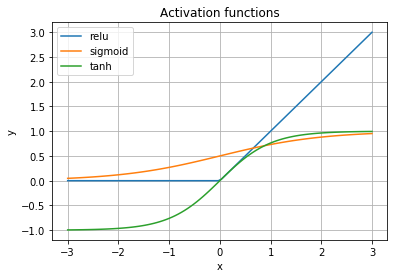

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [289]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    
    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    path = 'data/cifar-10-batches-py/data_batch_'
    all_batches = []
    all_labels = []
    for b in range(1,6):
        data, label = unpickle(path + str(b))
        batch = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        labels = np.array(label)
        all_batches.append(batch)
        all_labels.append(labels)
    data_train = np.concatenate(all_batches)
    labels_train = np.concatenate(all_labels)
    return data_train[:num_training, :, :, :], labels_train[:num_training], data_train[num_training:num_training + num_validation, :, :, :], labels_train[num_training:num_training + num_validation]
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    path = 'data/cifar-10-batches-py/test_batch'
    data, label = unpickle(path)
    batch = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    labels = np.array(label)
    
    return batch, labels
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [306]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.05))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def flatten(input):
    return tf.contrib.layers.flatten(input)

def fully_con(input, num_outputs):
    #flattened_shape = np.array(input.get_shape().as_list()[1:]).prod()
    W = tf.get_variable('w1', [input.get_shape()[1], num_outputs], tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b1', [num_outputs], initializer=tf.constant_initializer(0.0))
    
    # Fully convolution layer.
    fc = tf.add(tf.matmul(input, W), b)  
    #tmp = tf.contrib.layers.xavier_initializer(uniform=True, seed=9999, dtype=tf.float32)
    #fc = tf.contrib.layers.fully_connected(input, num_outputs, activation_fn=None)
    return fc

def loss(logits, y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

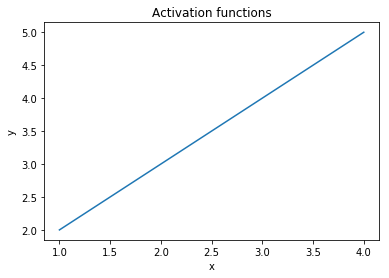

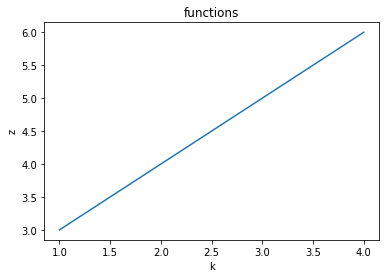

In [291]:
x = [1,2,3,4]
y1 = [2,3,4,5]
y2 = [3,4,5,6]
plt.figure(1)
plt.plot(x, y1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Activation functions")
plt.legend()
plt.figure(2)
plt.plot(x, y2)
plt.xlabel('k')
plt.ylabel('z')

plt.title("functions")
plt.legend()
plt.show()

In [292]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()
    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_con(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fully_con(self.relu3, 10)
            #self.fc4 = tf.nn.relu(self.fc4)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #self.global_step = tf.placeholder(tf.int32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(5e-4, self.global_step, 500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss_op, global_step=self.global_step)  
        #self.train_op = tf.train.AdamOptimizer().minimize(self.loss_op)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = loss(logits, labels)     
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_,
                    self.keep_prob: 1.0
                }                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            plt.figure(1)
            plt.plot([x for x in range(len(losses))], losses)
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.title("Loss Chart")
            plt.legend()
            plt.figure(2)
            plt.plot([x for x in range(len(accuracies))], accuracies)
            plt.xlabel('iteration')
            plt.ylabel('accuracy')

            plt.title("Accuracy Chart")
            plt.legend()
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {
                self.X: X_,
                self.Y: Y_,
                self.keep_prob: 1.0
            }
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 6.125, accuracy = 0.117
iteration (50): loss = 1.907, accuracy = 0.328
iteration (100): loss = 1.437, accuracy = 0.445
iteration (150): loss = 1.404, accuracy = 0.461
iteration (200): loss = 1.527, accuracy = 0.414
iteration (250): loss = 1.403, accuracy = 0.500
iteration (300): loss = 1.229, accuracy = 0.578
iteration (350): loss = 1.435, accuracy = 0.445


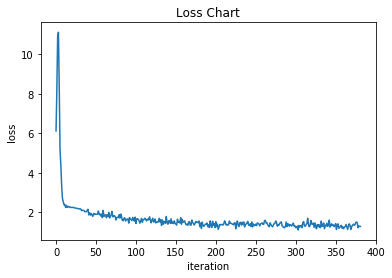

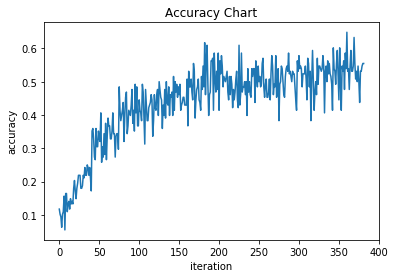

validation for epoch 0
-  epoch 0: validation accuracy = 0.575
train for epoch 1
iteration (400): loss = 1.254, accuracy = 0.562
iteration (450): loss = 1.258, accuracy = 0.539
iteration (500): loss = 1.243, accuracy = 0.539
iteration (550): loss = 1.104, accuracy = 0.633
iteration (600): loss = 1.135, accuracy = 0.609
iteration (650): loss = 1.377, accuracy = 0.516
iteration (700): loss = 1.047, accuracy = 0.656
iteration (750): loss = 1.137, accuracy = 0.648


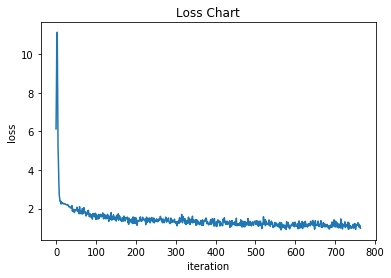

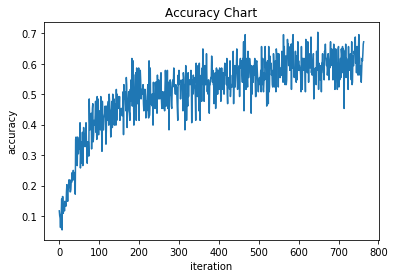

validation for epoch 1
-  epoch 1: validation accuracy = 0.610
train for epoch 2
iteration (800): loss = 0.926, accuracy = 0.641
iteration (850): loss = 1.157, accuracy = 0.594
iteration (900): loss = 0.930, accuracy = 0.672
iteration (950): loss = 0.818, accuracy = 0.719
iteration (1000): loss = 0.812, accuracy = 0.688
iteration (1050): loss = 0.966, accuracy = 0.648
iteration (1100): loss = 0.775, accuracy = 0.711


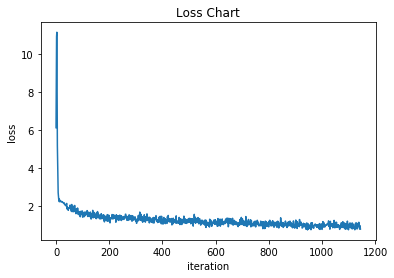

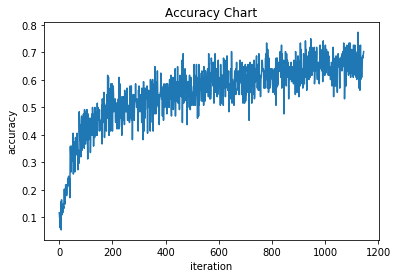

validation for epoch 2
-  epoch 2: validation accuracy = 0.622
train for epoch 3
iteration (1150): loss = 0.946, accuracy = 0.656
iteration (1200): loss = 0.839, accuracy = 0.648
iteration (1250): loss = 1.035, accuracy = 0.656
iteration (1300): loss = 1.061, accuracy = 0.578
iteration (1350): loss = 0.711, accuracy = 0.758
iteration (1400): loss = 0.880, accuracy = 0.750
iteration (1450): loss = 0.738, accuracy = 0.758
iteration (1500): loss = 0.778, accuracy = 0.711


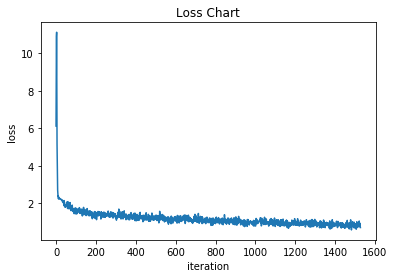

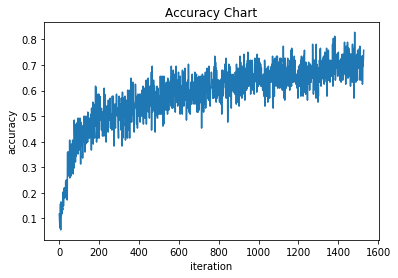

validation for epoch 3
-  epoch 3: validation accuracy = 0.615
train for epoch 4
iteration (1550): loss = 0.669, accuracy = 0.797
iteration (1600): loss = 0.786, accuracy = 0.719
iteration (1650): loss = 0.758, accuracy = 0.719
iteration (1700): loss = 0.740, accuracy = 0.750
iteration (1750): loss = 0.783, accuracy = 0.766
iteration (1800): loss = 0.658, accuracy = 0.797
iteration (1850): loss = 0.909, accuracy = 0.680
iteration (1900): loss = 0.630, accuracy = 0.789


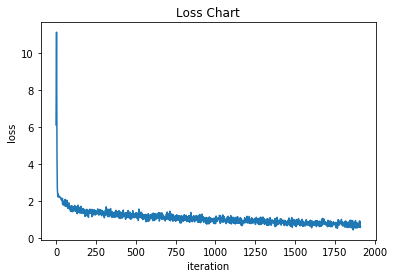

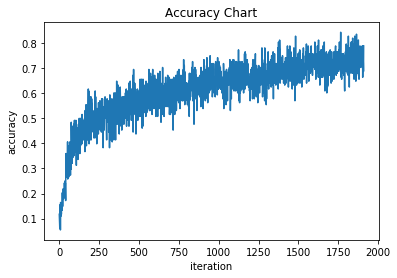

validation for epoch 4
-  epoch 4: validation accuracy = 0.604
***** test accuracy: 0.613
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [293]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [294]:
def avg_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.avg_pool(input, ksize=ksize, strides=strides, padding='SAME')

def normalize(x):
    ans = np.zeros(tuple(x.shape))
    cnt = x.shape[0]
    max_val, min_val = x.max(), x.min()
    for i in range(cnt):
        ans[i,...] = (x[i, ...] - float(min_val)) / float(max_val - min_val)
    return ans

In [310]:
class YourModel(object):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 40
        self.batch_size = 128
        self.log_step = 50
        self._build_model()
        
    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #self.global_step = tf.placeholder(tf.int32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)
        
        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 5, 1, 192)
            #self.conv1 = tf.nn.local_response_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.conv1)
            #self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.relu1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.relu1, 1, 1, 160)
            #self.conv2 = tf.nn.local_response_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.conv2)
            #self.pool2 = max_pool(self.relu2, 3, 2)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.relu2.get_shape()))

        with tf.variable_scope('conv3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv3 = conv2d(self.relu2, 1, 1, 96)
            #self.conv3 = tf.nn.local_response_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.conv3)
            self.relu3 = max_pool(self.relu3, 3, 2)    
            self.relu3 = tf.nn.dropout(self.relu3, self.keep_prob)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv3 layer: ' + str(self.relu3.get_shape()))
        
        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.relu3, 5, 1, 192)
            self.relu4 = tf.nn.relu(self.conv4)
            print('conv4 layer: ' + str(self.relu4.get_shape()))
            
        with tf.variable_scope('conv5'):
            self.conv5 = conv2d(self.relu4, 1, 1, 192)
            self.relu5 = tf.nn.relu(self.conv5)
            print('conv5 layer: ' + str(self.relu5.get_shape()))
            
        with tf.variable_scope('conv6'):
            self.conv6 = conv2d(self.relu5, 1, 1, 192)
            self.relu6 = tf.nn.relu(self.conv6)
            self.relu6 = avg_pool(self.relu6, 3, 2)
            self.relu6 = tf.nn.dropout(self.relu6, self.keep_prob)
            print('conv6 layer: ' + str(self.relu6.get_shape()))
            
        with tf.variable_scope('conv7'):
            self.conv7 = conv2d(self.relu6, 3, 1, 192)
            self.relu7 = tf.nn.relu(self.conv7)
            print('conv7 layer: ' + str(self.relu7.get_shape()))
            
        with tf.variable_scope('conv8'):
            self.conv8 = conv2d(self.relu7, 1, 1, 192)
            self.relu8 = tf.nn.relu(self.conv8)
            print('conv8 layer: ' + str(self.relu8.get_shape()))
            
        with tf.variable_scope('conv9'):
            self.conv9 = conv2d(self.relu8, 1, 1, 10)
            self.relu9 = tf.nn.relu(self.conv9)
            self.relu9 = avg_pool(self.relu9, 8, 8)
            print('conv9 layer: ' + str(self.relu9.get_shape()))
        self.flat = flatten(self.relu9)
        return self.flat
        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        #self.flat = flatten(self.pool3)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        #print('flat layer: ' + str(self.flat.get_shape()))

        #with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            #self.fc3 = fully_con(self.flat, 384)
            #self.relu3 = tf.nn.relu(self.fc3)
            #self.relu3 = tf.nn.dropout(self.relu3, self.keep_prob) 
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            #print('fc3 layer: ' + str(self.relu3.get_shape()))

        #with tf.variable_scope('fc4'):
            #self.fc4 = fully_con(self.relu3, 192)
            #self.relu4 = tf.nn.relu(self.fc4)
            #self.dropout = tf.nn.dropout(self.relu4, self.keep_prob) 
            #print('fc4 layer: ' + str(self.dropout.get_shape()))
            
        #with tf.variable_scope('fc5'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            #self.fc5 = fully_con(self.dropout, 10) 
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            #print('fc5 layer: ' + str(self.fc5.get_shape()))
        
        #return self.fc5

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #self.global_step = tf.placeholder(tf.int32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(5e-4, self.global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss_op, global_step=self.global_step)  
        #self.train_op = tf.train.AdamOptimizer().minimize(self.loss_op)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = loss(logits, labels)     
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_,
                    self.keep_prob: 0.5
                }                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            plt.figure(1)
            plt.plot([x for x in range(len(losses))], losses)
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.title("Loss Chart")
            plt.legend()
            plt.figure(2)
            plt.plot([x for x in range(len(accuracies))], accuracies)
            plt.xlabel('iteration')
            plt.ylabel('accuracy')

            plt.title("Accuracy Chart")
            plt.legend()
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {
                self.X: X_,
                self.Y: Y_,
                self.keep_prob: 1.0
            }
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 192)
conv2 layer: (?, 32, 32, 160)
conv3 layer: (?, 16, 16, 96)
conv4 layer: (?, 16, 16, 192)
conv5 layer: (?, 16, 16, 192)
conv6 layer: (?, 8, 8, 192)
conv7 layer: (?, 8, 8, 192)
conv8 layer: (?, 8, 8, 192)
conv9 layer: (?, 1, 1, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.303, accuracy = 0.109
iteration (50): loss = 2.176, accuracy = 0.219
iteration (100): loss = 2.141, accuracy = 0.203
iteration (150): loss = 2.115, accuracy = 0.242
iteration (200): loss = 2.164, accuracy = 0.211
iteration (250): loss = 2.087, accuracy = 0.234
iteration (300): loss = 1.850, accuracy = 0.391
iteration (350): loss = 1.874, accuracy = 0.312


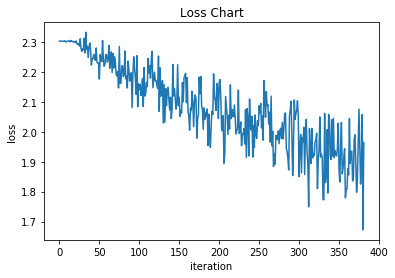

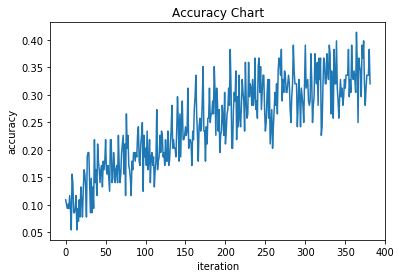

validation for epoch 0
-  epoch 0: validation accuracy = 0.368
train for epoch 1
iteration (400): loss = 1.830, accuracy = 0.383
iteration (450): loss = 1.911, accuracy = 0.336
iteration (500): loss = 1.913, accuracy = 0.344
iteration (550): loss = 1.695, accuracy = 0.445
iteration (600): loss = 1.759, accuracy = 0.398
iteration (650): loss = 1.775, accuracy = 0.367
iteration (700): loss = 1.779, accuracy = 0.438
iteration (750): loss = 1.545, accuracy = 0.492


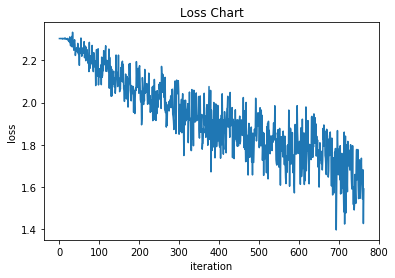

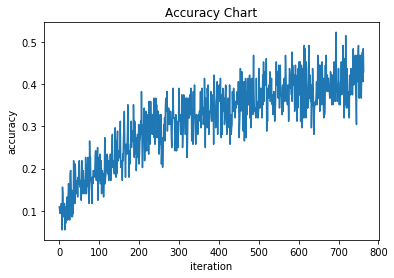

validation for epoch 1
-  epoch 1: validation accuracy = 0.456
train for epoch 2
iteration (800): loss = 1.456, accuracy = 0.484
iteration (850): loss = 1.699, accuracy = 0.375
iteration (900): loss = 1.562, accuracy = 0.422
iteration (950): loss = 1.370, accuracy = 0.516
iteration (1000): loss = 1.624, accuracy = 0.422
iteration (1050): loss = 1.295, accuracy = 0.516
iteration (1100): loss = 1.304, accuracy = 0.516


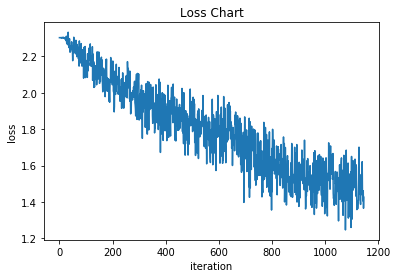

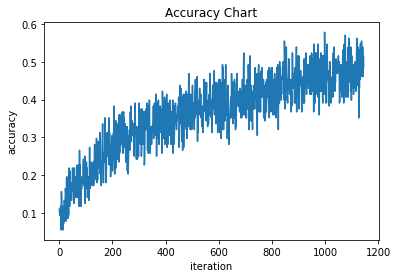

validation for epoch 2
-  epoch 2: validation accuracy = 0.503
train for epoch 3
iteration (1150): loss = 1.425, accuracy = 0.578
iteration (1200): loss = 1.343, accuracy = 0.516
iteration (1250): loss = 1.443, accuracy = 0.477
iteration (1300): loss = 1.489, accuracy = 0.438
iteration (1350): loss = 1.240, accuracy = 0.594
iteration (1400): loss = 1.365, accuracy = 0.516
iteration (1450): loss = 1.412, accuracy = 0.414
iteration (1500): loss = 1.392, accuracy = 0.539


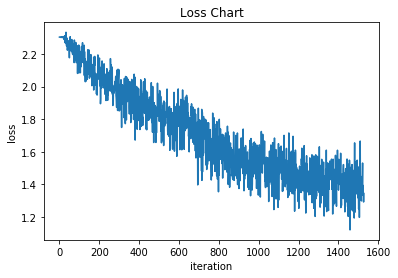

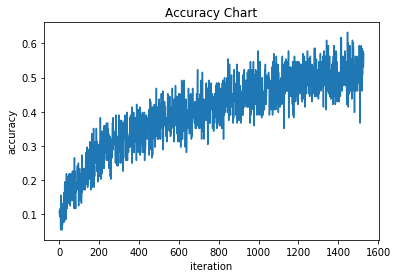

validation for epoch 3
-  epoch 3: validation accuracy = 0.564
train for epoch 4
iteration (1550): loss = 1.243, accuracy = 0.555
iteration (1600): loss = 1.291, accuracy = 0.617
iteration (1650): loss = 1.245, accuracy = 0.570
iteration (1700): loss = 1.315, accuracy = 0.500
iteration (1750): loss = 1.409, accuracy = 0.570
iteration (1800): loss = 1.278, accuracy = 0.555
iteration (1850): loss = 1.340, accuracy = 0.516
iteration (1900): loss = 1.366, accuracy = 0.516


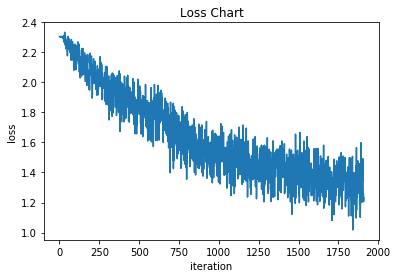

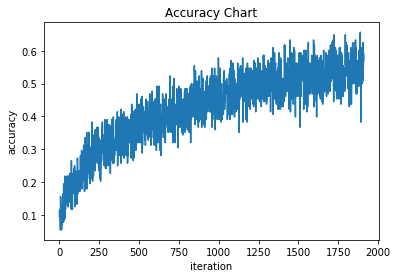

validation for epoch 4
-  epoch 4: validation accuracy = 0.579
train for epoch 5
iteration (1950): loss = 1.356, accuracy = 0.516
iteration (2000): loss = 1.152, accuracy = 0.578
iteration (2050): loss = 1.412, accuracy = 0.492
iteration (2100): loss = 1.339, accuracy = 0.531
iteration (2150): loss = 1.310, accuracy = 0.523
iteration (2200): loss = 1.355, accuracy = 0.539
iteration (2250): loss = 1.225, accuracy = 0.617


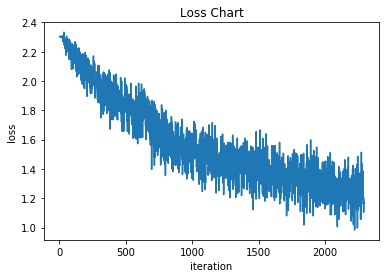

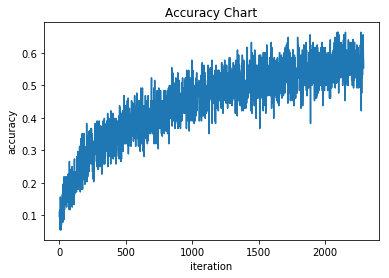

validation for epoch 5
-  epoch 5: validation accuracy = 0.606
train for epoch 6
iteration (2300): loss = 1.123, accuracy = 0.562
iteration (2350): loss = 1.266, accuracy = 0.594
iteration (2400): loss = 1.356, accuracy = 0.508
iteration (2450): loss = 1.357, accuracy = 0.570
iteration (2500): loss = 1.252, accuracy = 0.570
iteration (2550): loss = 1.246, accuracy = 0.547
iteration (2600): loss = 1.141, accuracy = 0.641
iteration (2650): loss = 1.097, accuracy = 0.586


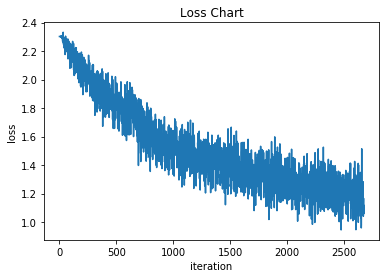

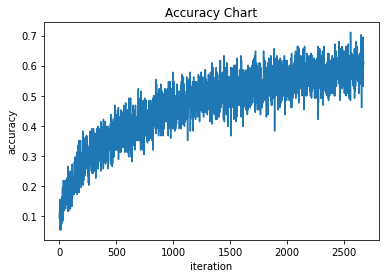

validation for epoch 6
-  epoch 6: validation accuracy = 0.618
train for epoch 7
iteration (2700): loss = 1.390, accuracy = 0.539
iteration (2750): loss = 1.109, accuracy = 0.625
iteration (2800): loss = 1.226, accuracy = 0.594
iteration (2850): loss = 1.148, accuracy = 0.617
iteration (2900): loss = 1.074, accuracy = 0.625
iteration (2950): loss = 1.178, accuracy = 0.578
iteration (3000): loss = 1.175, accuracy = 0.578
iteration (3050): loss = 1.112, accuracy = 0.602


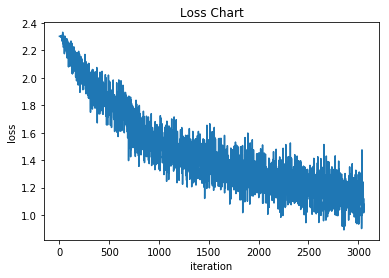

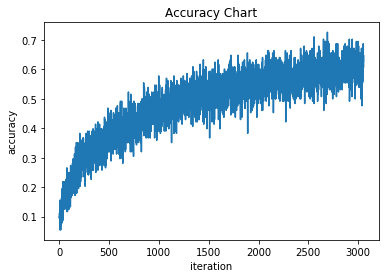

validation for epoch 7
-  epoch 7: validation accuracy = 0.621
train for epoch 8
iteration (3100): loss = 1.257, accuracy = 0.539
iteration (3150): loss = 1.339, accuracy = 0.547
iteration (3200): loss = 1.093, accuracy = 0.586
iteration (3250): loss = 1.140, accuracy = 0.547
iteration (3300): loss = 0.946, accuracy = 0.727
iteration (3350): loss = 1.203, accuracy = 0.625
iteration (3400): loss = 1.093, accuracy = 0.609


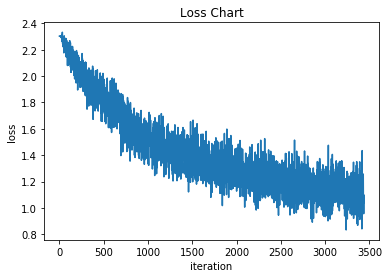

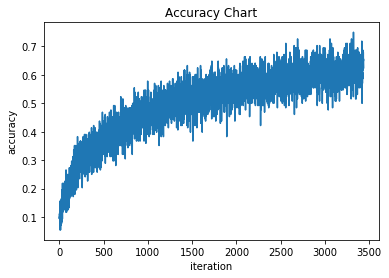

validation for epoch 8
-  epoch 8: validation accuracy = 0.627
train for epoch 9
iteration (3450): loss = 1.081, accuracy = 0.633
iteration (3500): loss = 1.176, accuracy = 0.609
iteration (3550): loss = 1.138, accuracy = 0.625
iteration (3600): loss = 0.942, accuracy = 0.688
iteration (3650): loss = 1.150, accuracy = 0.594
iteration (3700): loss = 1.141, accuracy = 0.625
iteration (3750): loss = 0.859, accuracy = 0.719
iteration (3800): loss = 1.121, accuracy = 0.617


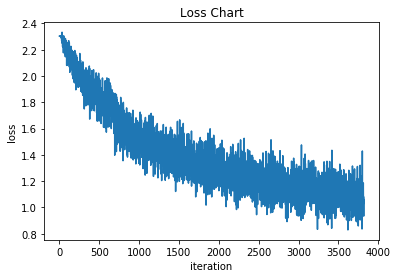

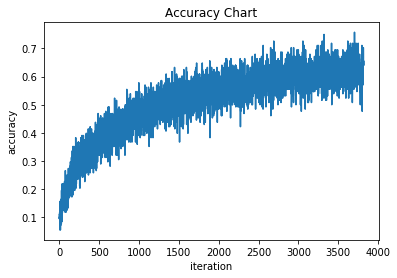

validation for epoch 9
-  epoch 9: validation accuracy = 0.652
train for epoch 10
iteration (3850): loss = 1.248, accuracy = 0.594
iteration (3900): loss = 1.168, accuracy = 0.602
iteration (3950): loss = 1.044, accuracy = 0.641
iteration (4000): loss = 1.029, accuracy = 0.633
iteration (4050): loss = 0.952, accuracy = 0.664
iteration (4100): loss = 1.135, accuracy = 0.625
iteration (4150): loss = 0.914, accuracy = 0.719
iteration (4200): loss = 0.922, accuracy = 0.688


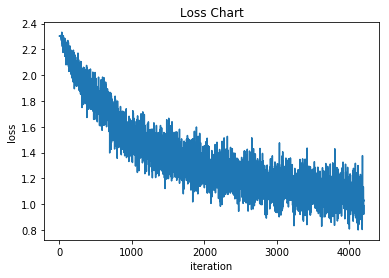

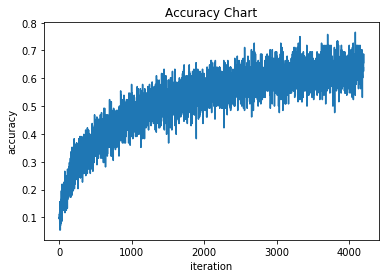

validation for epoch 10
-  epoch 10: validation accuracy = 0.632
train for epoch 11
iteration (4250): loss = 0.999, accuracy = 0.633
iteration (4300): loss = 0.959, accuracy = 0.664
iteration (4350): loss = 1.154, accuracy = 0.609
iteration (4400): loss = 1.114, accuracy = 0.609
iteration (4450): loss = 0.983, accuracy = 0.656
iteration (4500): loss = 0.984, accuracy = 0.609
iteration (4550): loss = 1.103, accuracy = 0.641


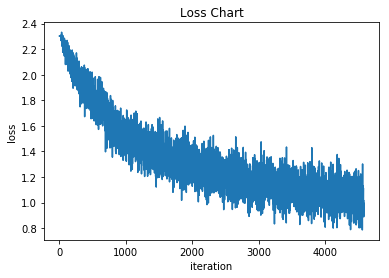

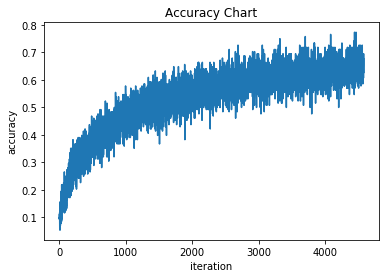

validation for epoch 11
-  epoch 11: validation accuracy = 0.653
train for epoch 12
iteration (4600): loss = 0.932, accuracy = 0.641
iteration (4650): loss = 0.998, accuracy = 0.617
iteration (4700): loss = 1.097, accuracy = 0.625
iteration (4750): loss = 1.026, accuracy = 0.664
iteration (4800): loss = 1.102, accuracy = 0.641
iteration (4850): loss = 0.864, accuracy = 0.734
iteration (4900): loss = 1.046, accuracy = 0.695
iteration (4950): loss = 1.085, accuracy = 0.641


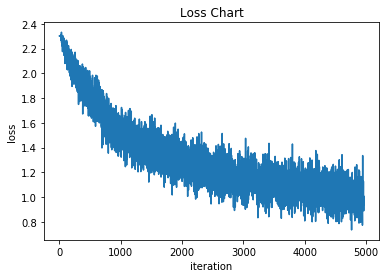

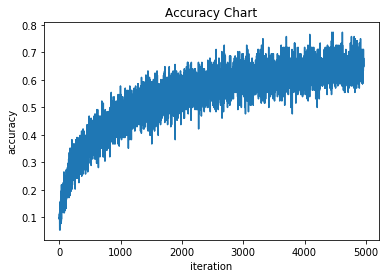

validation for epoch 12
-  epoch 12: validation accuracy = 0.669
train for epoch 13
iteration (5000): loss = 0.818, accuracy = 0.750
iteration (5050): loss = 0.906, accuracy = 0.672
iteration (5100): loss = 0.959, accuracy = 0.664
iteration (5150): loss = 0.930, accuracy = 0.695
iteration (5200): loss = 0.860, accuracy = 0.695
iteration (5250): loss = 1.056, accuracy = 0.656
iteration (5300): loss = 1.007, accuracy = 0.664


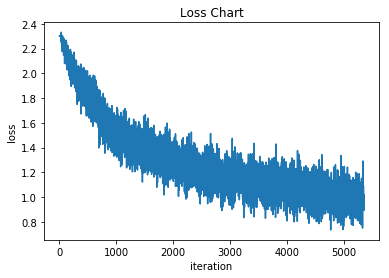

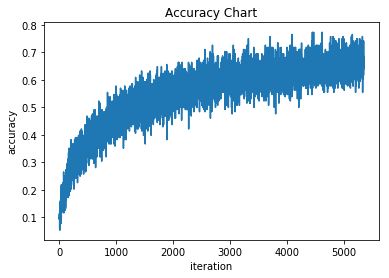

validation for epoch 13
-  epoch 13: validation accuracy = 0.684
train for epoch 14
iteration (5350): loss = 1.070, accuracy = 0.625
iteration (5400): loss = 0.957, accuracy = 0.680
iteration (5450): loss = 0.942, accuracy = 0.648
iteration (5500): loss = 0.911, accuracy = 0.688
iteration (5550): loss = 0.995, accuracy = 0.680
iteration (5600): loss = 0.995, accuracy = 0.656
iteration (5650): loss = 0.972, accuracy = 0.664
iteration (5700): loss = 1.096, accuracy = 0.625


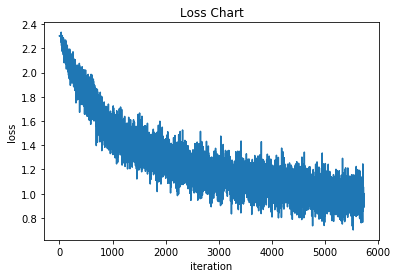

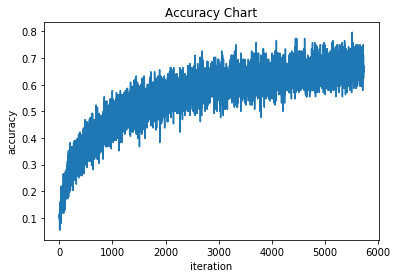

validation for epoch 14
-  epoch 14: validation accuracy = 0.679
train for epoch 15
iteration (5750): loss = 0.846, accuracy = 0.695
iteration (5800): loss = 1.175, accuracy = 0.609
iteration (5850): loss = 0.826, accuracy = 0.734
iteration (5900): loss = 0.944, accuracy = 0.672
iteration (5950): loss = 0.905, accuracy = 0.648
iteration (6000): loss = 0.844, accuracy = 0.734
iteration (6050): loss = 0.917, accuracy = 0.719
iteration (6100): loss = 1.000, accuracy = 0.625


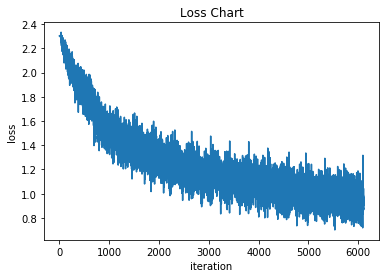

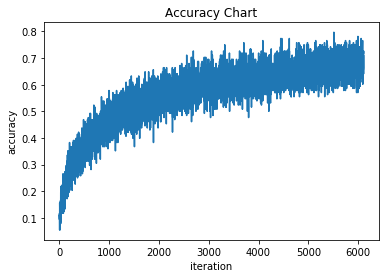

validation for epoch 15
-  epoch 15: validation accuracy = 0.673
train for epoch 16
iteration (6150): loss = 1.077, accuracy = 0.617
iteration (6200): loss = 0.848, accuracy = 0.695
iteration (6250): loss = 0.917, accuracy = 0.711
iteration (6300): loss = 0.922, accuracy = 0.633
iteration (6350): loss = 0.939, accuracy = 0.688
iteration (6400): loss = 1.000, accuracy = 0.625
iteration (6450): loss = 1.005, accuracy = 0.648


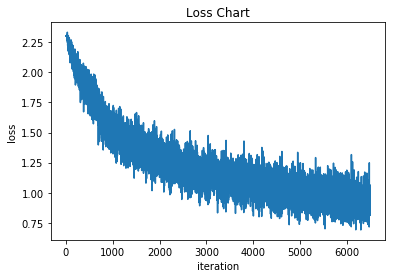

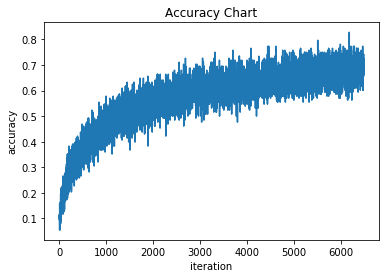

validation for epoch 16
-  epoch 16: validation accuracy = 0.688
train for epoch 17
iteration (6500): loss = 0.837, accuracy = 0.703
iteration (6550): loss = 0.828, accuracy = 0.695
iteration (6600): loss = 1.037, accuracy = 0.672
iteration (6650): loss = 1.034, accuracy = 0.633
iteration (6700): loss = 0.888, accuracy = 0.711
iteration (6750): loss = 0.942, accuracy = 0.711
iteration (6800): loss = 0.917, accuracy = 0.688
iteration (6850): loss = 0.814, accuracy = 0.703


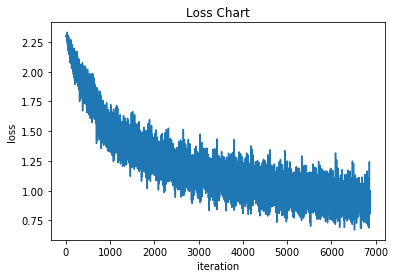

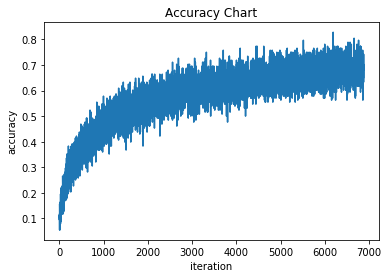

validation for epoch 17
-  epoch 17: validation accuracy = 0.692
train for epoch 18
iteration (6900): loss = 0.949, accuracy = 0.641
iteration (6950): loss = 0.712, accuracy = 0.812
iteration (7000): loss = 0.929, accuracy = 0.688
iteration (7050): loss = 0.893, accuracy = 0.703
iteration (7100): loss = 0.926, accuracy = 0.680
iteration (7150): loss = 0.823, accuracy = 0.734
iteration (7200): loss = 0.960, accuracy = 0.648
iteration (7250): loss = 0.967, accuracy = 0.664


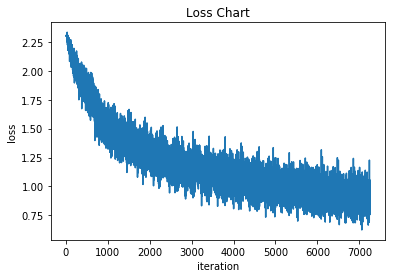

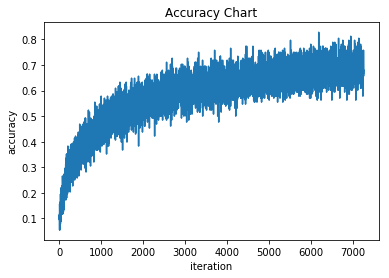

validation for epoch 18
-  epoch 18: validation accuracy = 0.710
train for epoch 19
iteration (7300): loss = 0.990, accuracy = 0.695
iteration (7350): loss = 0.993, accuracy = 0.680
iteration (7400): loss = 0.953, accuracy = 0.680
iteration (7450): loss = 0.993, accuracy = 0.656
iteration (7500): loss = 0.833, accuracy = 0.719
iteration (7550): loss = 0.744, accuracy = 0.742
iteration (7600): loss = 0.845, accuracy = 0.727


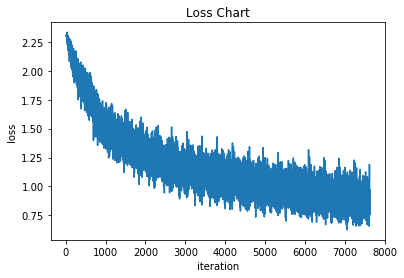

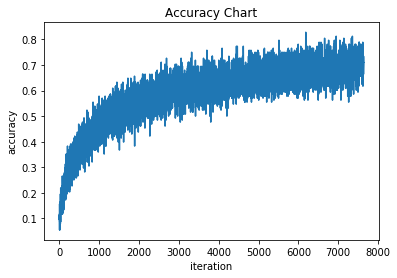

validation for epoch 19
-  epoch 19: validation accuracy = 0.702
train for epoch 20
iteration (7650): loss = 0.892, accuracy = 0.711
iteration (7700): loss = 0.793, accuracy = 0.719
iteration (7750): loss = 0.848, accuracy = 0.711
iteration (7800): loss = 0.824, accuracy = 0.695
iteration (7850): loss = 0.846, accuracy = 0.758
iteration (7900): loss = 0.924, accuracy = 0.695
iteration (7950): loss = 1.001, accuracy = 0.641
iteration (8000): loss = 0.680, accuracy = 0.797


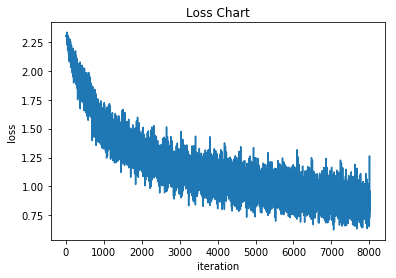

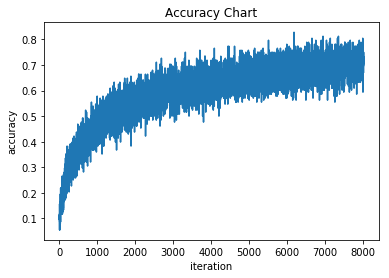

validation for epoch 20
-  epoch 20: validation accuracy = 0.710
train for epoch 21
iteration (8050): loss = 0.721, accuracy = 0.766
iteration (8100): loss = 0.769, accuracy = 0.742
iteration (8150): loss = 0.988, accuracy = 0.625
iteration (8200): loss = 0.917, accuracy = 0.695
iteration (8250): loss = 0.869, accuracy = 0.688
iteration (8300): loss = 0.823, accuracy = 0.719
iteration (8350): loss = 0.920, accuracy = 0.703
iteration (8400): loss = 0.794, accuracy = 0.695


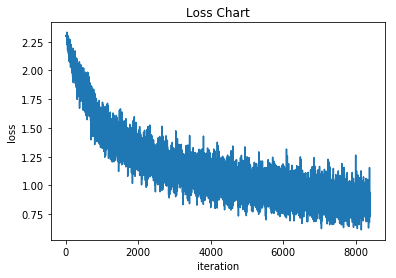

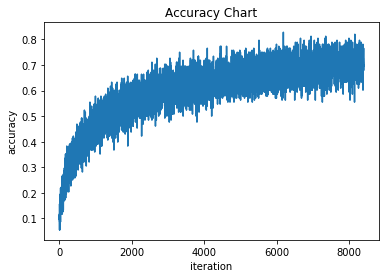

validation for epoch 21
-  epoch 21: validation accuracy = 0.708
train for epoch 22
iteration (8450): loss = 0.794, accuracy = 0.711
iteration (8500): loss = 0.947, accuracy = 0.656
iteration (8550): loss = 0.898, accuracy = 0.680
iteration (8600): loss = 0.864, accuracy = 0.711
iteration (8650): loss = 0.727, accuracy = 0.781
iteration (8700): loss = 0.963, accuracy = 0.656
iteration (8750): loss = 0.721, accuracy = 0.781


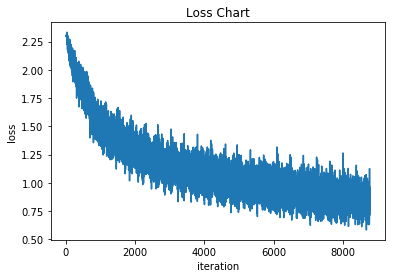

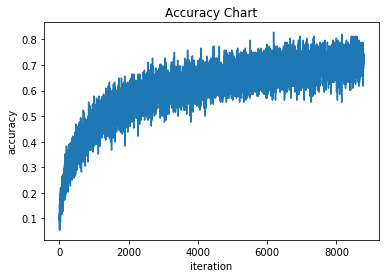

validation for epoch 22
-  epoch 22: validation accuracy = 0.719
train for epoch 23
iteration (8800): loss = 0.740, accuracy = 0.773
iteration (8850): loss = 0.902, accuracy = 0.695
iteration (8900): loss = 0.900, accuracy = 0.680
iteration (8950): loss = 0.857, accuracy = 0.711
iteration (9000): loss = 0.913, accuracy = 0.656
iteration (9050): loss = 0.868, accuracy = 0.688
iteration (9100): loss = 0.770, accuracy = 0.781
iteration (9150): loss = 0.784, accuracy = 0.727


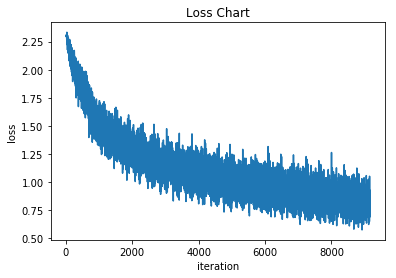

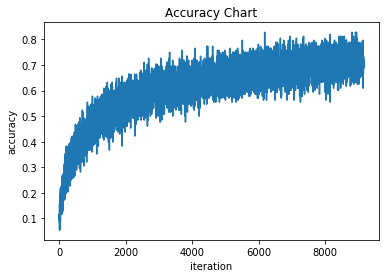

validation for epoch 23
-  epoch 23: validation accuracy = 0.720
train for epoch 24
iteration (9200): loss = 0.848, accuracy = 0.727
iteration (9250): loss = 0.929, accuracy = 0.711
iteration (9300): loss = 0.751, accuracy = 0.742
iteration (9350): loss = 0.613, accuracy = 0.797
iteration (9400): loss = 0.781, accuracy = 0.750
iteration (9450): loss = 0.789, accuracy = 0.727
iteration (9500): loss = 0.870, accuracy = 0.664


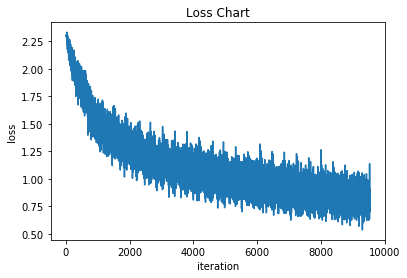

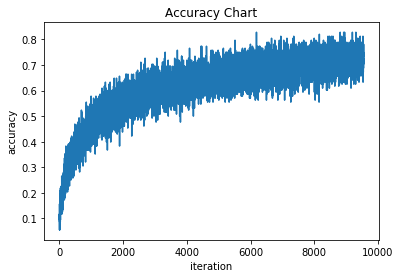

validation for epoch 24
-  epoch 24: validation accuracy = 0.711
train for epoch 25
iteration (9550): loss = 0.698, accuracy = 0.773
iteration (9600): loss = 0.731, accuracy = 0.789
iteration (9650): loss = 0.753, accuracy = 0.703
iteration (9700): loss = 0.890, accuracy = 0.711
iteration (9750): loss = 0.861, accuracy = 0.703
iteration (9800): loss = 0.922, accuracy = 0.711
iteration (9850): loss = 0.727, accuracy = 0.742
iteration (9900): loss = 0.879, accuracy = 0.703


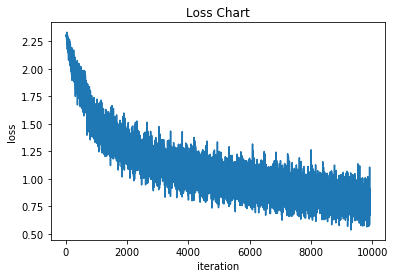

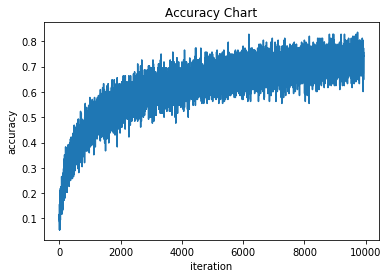

validation for epoch 25
-  epoch 25: validation accuracy = 0.728
train for epoch 26
iteration (9950): loss = 0.845, accuracy = 0.711
iteration (10000): loss = 0.836, accuracy = 0.711
iteration (10050): loss = 0.736, accuracy = 0.750
iteration (10100): loss = 0.720, accuracy = 0.766
iteration (10150): loss = 0.799, accuracy = 0.727
iteration (10200): loss = 0.807, accuracy = 0.688
iteration (10250): loss = 0.808, accuracy = 0.773
iteration (10300): loss = 0.708, accuracy = 0.766


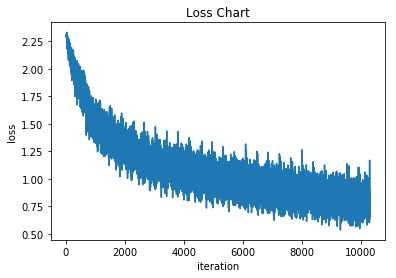

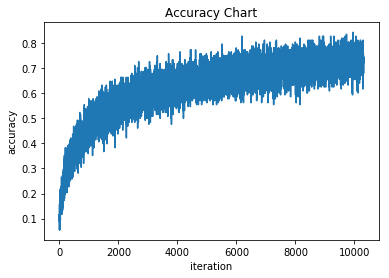

validation for epoch 26
-  epoch 26: validation accuracy = 0.733
train for epoch 27
iteration (10350): loss = 0.642, accuracy = 0.797
iteration (10400): loss = 0.977, accuracy = 0.664
iteration (10450): loss = 0.791, accuracy = 0.750
iteration (10500): loss = 0.725, accuracy = 0.805
iteration (10550): loss = 0.732, accuracy = 0.773
iteration (10600): loss = 0.718, accuracy = 0.742
iteration (10650): loss = 0.586, accuracy = 0.789


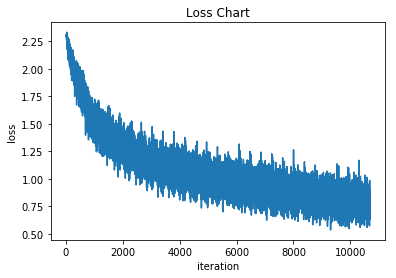

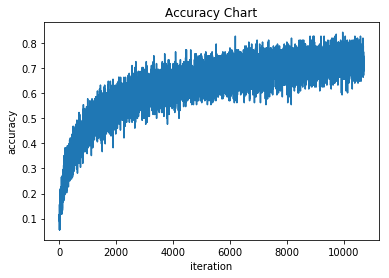

validation for epoch 27
-  epoch 27: validation accuracy = 0.740
train for epoch 28
iteration (10700): loss = 0.733, accuracy = 0.742
iteration (10750): loss = 0.646, accuracy = 0.758
iteration (10800): loss = 0.750, accuracy = 0.750
iteration (10850): loss = 0.882, accuracy = 0.688
iteration (10900): loss = 0.634, accuracy = 0.781
iteration (10950): loss = 0.739, accuracy = 0.758
iteration (11000): loss = 0.891, accuracy = 0.672
iteration (11050): loss = 0.774, accuracy = 0.727


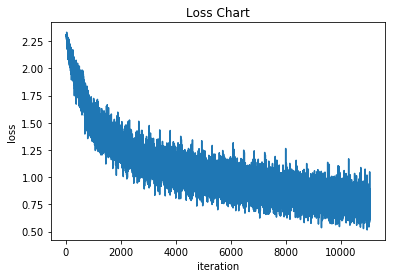

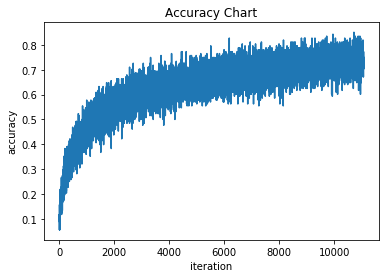

validation for epoch 28
-  epoch 28: validation accuracy = 0.732
train for epoch 29
iteration (11100): loss = 0.665, accuracy = 0.797
iteration (11150): loss = 0.839, accuracy = 0.734
iteration (11200): loss = 0.743, accuracy = 0.766
iteration (11250): loss = 0.708, accuracy = 0.766
iteration (11300): loss = 0.779, accuracy = 0.727
iteration (11350): loss = 0.506, accuracy = 0.836
iteration (11400): loss = 0.808, accuracy = 0.750
iteration (11450): loss = 0.850, accuracy = 0.695


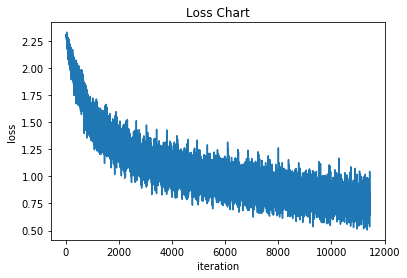

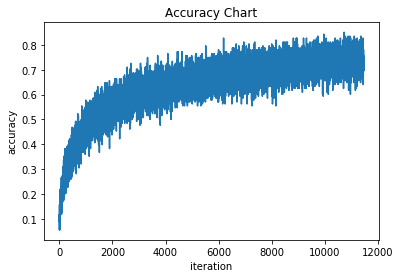

validation for epoch 29
-  epoch 29: validation accuracy = 0.731
train for epoch 30
iteration (11500): loss = 0.734, accuracy = 0.758
iteration (11550): loss = 0.697, accuracy = 0.750
iteration (11600): loss = 0.850, accuracy = 0.695
iteration (11650): loss = 0.907, accuracy = 0.656
iteration (11700): loss = 0.877, accuracy = 0.703
iteration (11750): loss = 0.766, accuracy = 0.719
iteration (11800): loss = 0.716, accuracy = 0.750


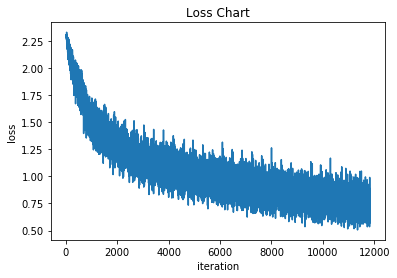

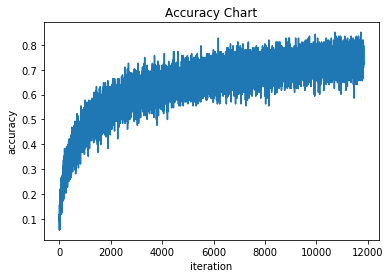

validation for epoch 30
-  epoch 30: validation accuracy = 0.735
train for epoch 31
iteration (11850): loss = 0.775, accuracy = 0.703
iteration (11900): loss = 0.863, accuracy = 0.664
iteration (11950): loss = 0.849, accuracy = 0.742
iteration (12000): loss = 0.775, accuracy = 0.742
iteration (12050): loss = 0.842, accuracy = 0.727
iteration (12100): loss = 0.716, accuracy = 0.750
iteration (12150): loss = 0.683, accuracy = 0.781
iteration (12200): loss = 0.657, accuracy = 0.805


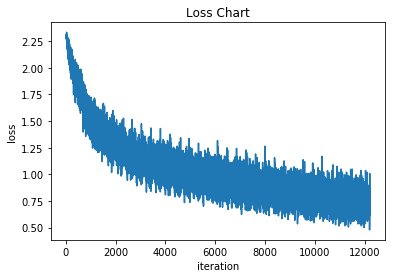

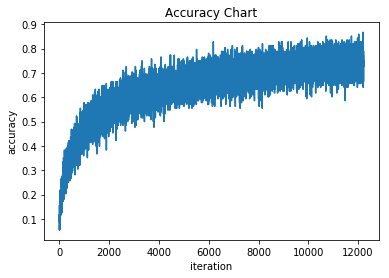

validation for epoch 31
-  epoch 31: validation accuracy = 0.743
train for epoch 32
iteration (12250): loss = 0.819, accuracy = 0.711
iteration (12300): loss = 0.741, accuracy = 0.766
iteration (12350): loss = 0.819, accuracy = 0.711
iteration (12400): loss = 0.620, accuracy = 0.789
iteration (12450): loss = 0.637, accuracy = 0.805
iteration (12500): loss = 0.714, accuracy = 0.742
iteration (12550): loss = 0.752, accuracy = 0.719
iteration (12600): loss = 0.769, accuracy = 0.750


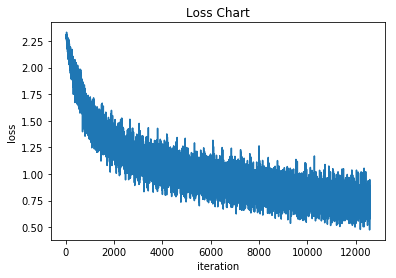

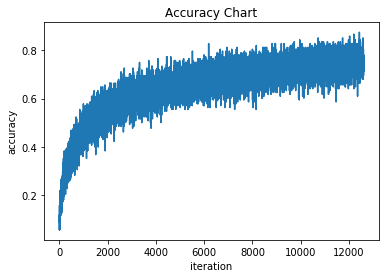

validation for epoch 32
-  epoch 32: validation accuracy = 0.742
train for epoch 33
iteration (12650): loss = 0.790, accuracy = 0.719
iteration (12700): loss = 0.813, accuracy = 0.719
iteration (12750): loss = 0.738, accuracy = 0.734
iteration (12800): loss = 0.726, accuracy = 0.742
iteration (12850): loss = 0.558, accuracy = 0.836
iteration (12900): loss = 0.784, accuracy = 0.727
iteration (12950): loss = 0.683, accuracy = 0.742


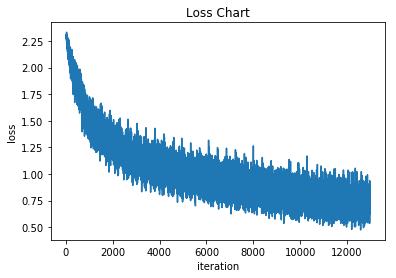

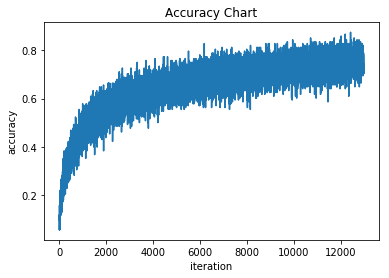

validation for epoch 33
-  epoch 33: validation accuracy = 0.751
train for epoch 34
iteration (13000): loss = 0.587, accuracy = 0.812
iteration (13050): loss = 0.753, accuracy = 0.758
iteration (13100): loss = 0.815, accuracy = 0.750
iteration (13150): loss = 0.777, accuracy = 0.742
iteration (13200): loss = 0.812, accuracy = 0.727
iteration (13250): loss = 0.882, accuracy = 0.703
iteration (13300): loss = 0.638, accuracy = 0.781
iteration (13350): loss = 0.721, accuracy = 0.766


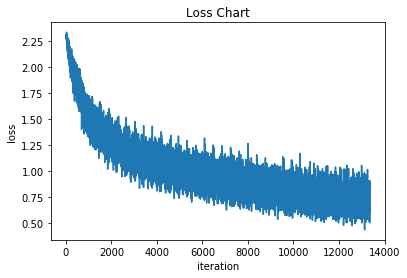

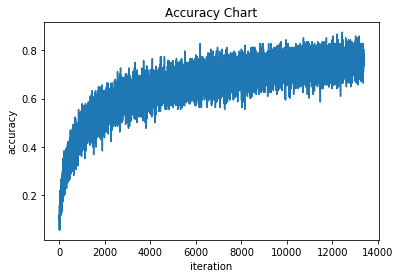

validation for epoch 34
-  epoch 34: validation accuracy = 0.750
train for epoch 35
iteration (13400): loss = 0.847, accuracy = 0.703
iteration (13450): loss = 0.738, accuracy = 0.750
iteration (13500): loss = 0.587, accuracy = 0.820
iteration (13550): loss = 0.788, accuracy = 0.719
iteration (13600): loss = 0.657, accuracy = 0.758
iteration (13650): loss = 0.667, accuracy = 0.758
iteration (13700): loss = 0.557, accuracy = 0.820
iteration (13750): loss = 0.734, accuracy = 0.766


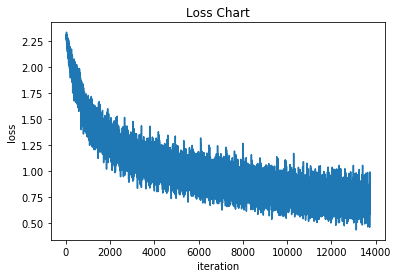

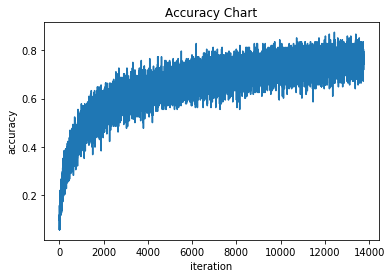

validation for epoch 35
-  epoch 35: validation accuracy = 0.747
train for epoch 36
iteration (13800): loss = 0.579, accuracy = 0.766
iteration (13850): loss = 0.490, accuracy = 0.828
iteration (13900): loss = 0.793, accuracy = 0.703
iteration (13950): loss = 0.751, accuracy = 0.750
iteration (14000): loss = 0.538, accuracy = 0.797
iteration (14050): loss = 0.688, accuracy = 0.781
iteration (14100): loss = 0.814, accuracy = 0.734


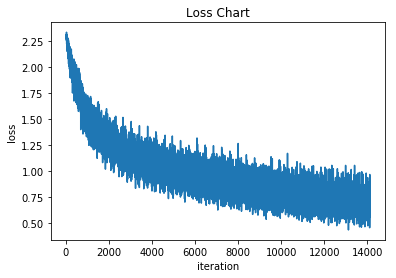

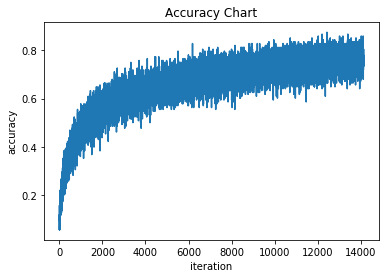

validation for epoch 36
-  epoch 36: validation accuracy = 0.748
train for epoch 37
iteration (14150): loss = 0.599, accuracy = 0.781
iteration (14200): loss = 0.751, accuracy = 0.773
iteration (14250): loss = 0.675, accuracy = 0.773
iteration (14300): loss = 0.669, accuracy = 0.812
iteration (14350): loss = 0.633, accuracy = 0.781
iteration (14400): loss = 0.599, accuracy = 0.820
iteration (14450): loss = 0.838, accuracy = 0.711
iteration (14500): loss = 0.750, accuracy = 0.750


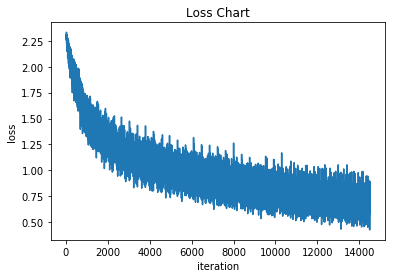

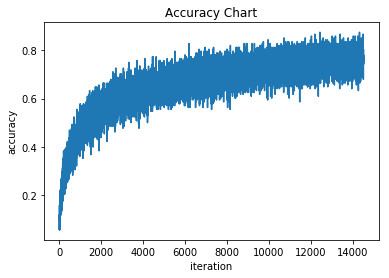

validation for epoch 37
-  epoch 37: validation accuracy = 0.740
train for epoch 38
iteration (14550): loss = 0.591, accuracy = 0.797
iteration (14600): loss = 0.720, accuracy = 0.734
iteration (14650): loss = 0.677, accuracy = 0.758
iteration (14700): loss = 0.598, accuracy = 0.781
iteration (14750): loss = 0.596, accuracy = 0.781
iteration (14800): loss = 0.755, accuracy = 0.727
iteration (14850): loss = 0.723, accuracy = 0.758


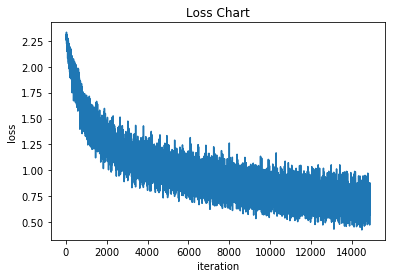

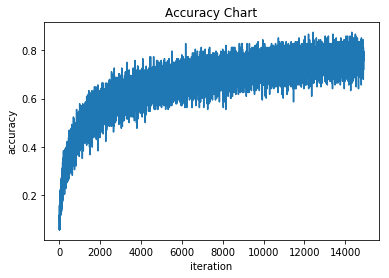

validation for epoch 38
-  epoch 38: validation accuracy = 0.741
train for epoch 39
iteration (14900): loss = 0.777, accuracy = 0.711
iteration (14950): loss = 0.575, accuracy = 0.789
iteration (15000): loss = 0.515, accuracy = 0.828
iteration (15050): loss = 0.608, accuracy = 0.789
iteration (15100): loss = 0.674, accuracy = 0.781
iteration (15150): loss = 0.680, accuracy = 0.758
iteration (15200): loss = 0.646, accuracy = 0.812
iteration (15250): loss = 0.804, accuracy = 0.727


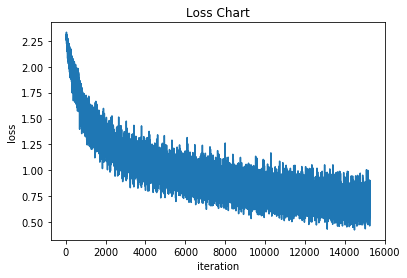

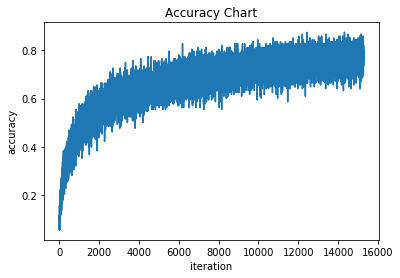

validation for epoch 39
-  epoch 39: validation accuracy = 0.734
***** test accuracy: 0.719
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [311]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = normalize(X_train)
X_val_ = normalize(X_val)
X_test_ = normalize(X_test)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [312]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 192)
conv2 layer: (?, 32, 32, 160)
conv3 layer: (?, 16, 16, 96)
conv4 layer: (?, 16, 16, 192)
conv5 layer: (?, 16, 16, 192)
conv6 layer: (?, 8, 8, 192)
conv7 layer: (?, 8, 8, 192)
conv8 layer: (?, 8, 8, 192)
conv9 layer: (?, 1, 1, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt


INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
